In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr

from datetime import date
import os
from scipy.io import loadmat
# load preset parameter values
from forecast_conf import (model_directory,x_location,y_location,range_pixels,target_lead_time,extra_data_lead_times,test_forecasts_per_set,test_time_1,test_time_2)
# import functions
from helper_functions import standardize_dims

## Pre-training

-This notebook is a work in progress-

Here, I pre-train the CNN model on all lead times of the forecast, and then train it on lead times near the target lead time.

In [136]:
# set parameters, if different than in forecast_conf

# location of data
x_location=271.5
y_location=28.19

# size of image to consider, in +/- from data location, in number of pixels
range_pixels=25

# which lead time to train on
target_lead_time=30

# how many extra data points to take on either side of the desired lead time, in order to increase data points
# note that forecasts are issued every week, so shouldn't use more 6 days before/after
extra_data_lead_times = 2

# upfront define the testing forecasts, since these will be removed from the training data altogether to minimize data leakage
# I will pull out the last 10 forecasts
F_test_forecast=list(range(84,94))


In [22]:
# load measurements from mat file
# C is current speed
# T is time
C = loadmat('TH_current_ADCP.mat')['C'].squeeze()
T = loadmat('TH_current_ADCP.mat')['T'].squeeze()

In [23]:
import datetime
# convert matlab times to datetime
pdate=pd.to_datetime(T-719529,unit='d').round('s').values


In [24]:
# put current measurements into an xarray for ease of use and re-time to daily mean
measurements= xr.Dataset({"Speed": (["time"], C)},coords={"time": pdate})
# retime to 2h means
measurements=measurements.resample(time="2H").mean()


/opt/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [25]:
''''''''''
Now, get a list of directories with forecast data.

The data is structured such that each forecast is in one directory, 
and within each directory there is a netcdf file for each lead time, a week apart (usually 46 files)

'''''''''
ls=[x[0] for x in os.walk('.')]
forecast_directories=[]
for x in ls:
    # forecast folders are labelled by date, so have "20" in the name
    if x.find('20') > 0:
        forecast_directories.append(x)

In [26]:
# make a list of all forecast files across all directories
forecast_file_list=[]

for y in forecast_directories:
    temp=[x[2] for x in os.walk(y)]
    for m in temp[0]:
        if m.find('.nc') > 0:
            forecast_file_list.append(y+'/'+m)     
            
# sort the list of all files            
forecast_file_list.sort()

# count total number of forecast used
number_of_forecasts=len(forecast_directories)



In [29]:
from datetime import datetime, timedelta


# create arrays to hold X and Y values for CNN
# dimensions are:
# Dims: (forecast, lead times within within forecast, number of ensemble members, x-pixels, y-pixels, number of fields)
X_data=np.empty((number_of_forecasts,46,32,2*range_pixels,2*range_pixels,4))

# Dims: (forecast, lead times within within forecast, number of ensemble members)
Y_data=np.empty((number_of_forecasts,46,32))


# parameters used for indexing
directory_index=0

current_directory=forecast_file_list[0][2:10]


# get indices for (x,y) measurement location
arr=xr.open_dataset(forecast_file_list[0])
arr=standardize_dims(arr)
lat=abs(arr.lat-y_location)
lon=abs(arr.lon-x_location)
y_location_index=np.argmin(lat.values)
x_location_index=np.argmin(lon.values)

In [30]:
# load the data in the correct format
for k in forecast_file_list:
    # check if moving to new forecast, and update current_directory if so
    if k[2:10] != current_directory:
        directory_index+=1
        current_directory=k[2:10]
        
    # calculate forecast lead time, in days
    # date of issue
    date1 = datetime.strptime(k[24:32], '%Y%m%d')
    # date of prediction
    date2 = datetime.strptime(k[33:41], '%Y%m%d')
    # lead time
    days_difference=(date2-date1).days
    

    arr=xr.open_dataset(k)
    arr=standardize_dims(arr)
    # load sea surface temperature
    t=arr.water_temp_mb.squeeze()
    # load current speed
    s=100*np.sqrt(arr.water_u_mb**2+arr.water_v_mb**2).squeeze()
    # load current direction
    ddir = np.arctan2(arr.water_u_mb, arr.water_v_mb).squeeze()
    # select (x,y) window
    t=t[:,y_location_index-range_pixels:y_location_index+range_pixels,x_location_index-range_pixels:x_location_index+range_pixels]
    s=s[:,y_location_index-range_pixels:y_location_index+range_pixels,x_location_index-range_pixels:x_location_index+range_pixels]
    ddir=ddir[:,y_location_index-range_pixels:y_location_index+range_pixels,x_location_index-range_pixels:x_location_index+range_pixels]
    # calculate ensemble means
    tm=t.mean(dim='ENSEMBLE')
    sm=s.mean(dim='ENSEMBLE')
    ddirm=ddir.mean(dim='ENSEMBLE')
    
    # get measurement at correct lead time
    val=measurements.sel(time=pd.to_datetime(date2), method="nearest").Speed.values


    for k in range(32):

        # put data into the array used for training and testing
        # here, you can choose which fields to use (speed, direction, seas surface temperature)
        # potential to add other measurement, and/or reanalyses fields such as wind, in the future
        # this should be vectorized, but there are some directories with less than 46 files
        X_data[directory_index,days_difference,k,:,:,0]=s[k%s.shape[0],:,:].values
        X_data[directory_index,days_difference,k,:,:,1]=sm.values
        #X_data[directory_index,days_difference,k,:,:,2]=ddir[k%s.shape[0],:,:].values
        #X_data[directory_index,days_difference,k,:,:,3]=ddirm.values           
        X_data[directory_index,days_difference,k,:,:,2]=t[k%s.shape[0],:,:].values
        #X_data[directory_index,days_difference,k,:,:,3]=tm.values                  
        X_data[directory_index,days_difference,k,:,:,3]=date2.month
        
    # create y-values dataset    
    for k in range(32):
            # read predicted current at measurement location
            mod=s[k%s.shape[0],:,:].sel(lon=271.5,lat=28.19, method="nearest").squeeze().values
            # save error for each ensemble member
            Y_data[directory_index,days_difference,k]=val-mod
  
 
    
    

In [140]:
'''''''''
Split the data into test and train

'''''''''





# define pre-training, training and testing forecasts

# pre-training on all lead times
L_pretrain=list(range(46))

# tesing only on target lead time
L_test= target_lead_time

# training on lead times near target lead time, using pre-defined parameters
L_train = list(range(target_lead_time-extra_data_lead_times,target_lead_time+extra_data_lead_times+1))
L_pretrain=np.delete(L_pretrain,range(target_lead_time-extra_data_lead_times,target_lead_time+extra_data_lead_times+1))
print('Lead times for pre-training: ',L_pretrain)
print('Lead times for training: ',L_train)
print('Lead times for testing: ',L_test)

# Gather list for forecast on which to train and test on
F_all=list(range(94))
F_all= np.delete(F_all,F_test_forecast)

print('Forecasts for training: ',F_all)
print('Forecasts for testing: ',F_test_forecast)

Lead times for pre-training:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 33 34 35 36 37 38 39 40 41 42 43 44 45]
Lead times for training:  [28, 29, 30, 31, 32]
Lead times for testing:  30
Forecasts for training:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83]
Forecasts for testing:  [84, 85, 86, 87, 88, 89, 90, 91, 92, 93]


In [ ]:
# populate arrays


X_data_pretrain=X_data[F_all[:,None],L_pretrain,:,:,:,:]
Y_data_pretrain=Y_data[F_all[:,None],L_pretrain,:]

X_data_train=X_data[F_all[:,None],L_train,:,:,:,:]
Y_data_train=Y_data[F_all[:,None],L_train,:]

X_data_test=X_data[F_test_forecast,L_test,:,:,:,:]
Y_data_test=Y_data[F_test_forecast,L_test,:]

X_data_pretrain=X_data_pretrain.reshape(np.array(X_data_pretrain.shape[:3]).prod(),2*range_pixels,2*range_pixels,4)
Y_data_pretrain=Y_data_pretrain.reshape(np.array(Y_data_pretrain.shape[:3]).prod(),1)

X_data_train=X_data_train.reshape(np.array(X_data_train.shape[:3]).prod(),2*range_pixels,2*range_pixels,4)
Y_data_train=Y_data_train.reshape(np.array(Y_data_train.shape[:3]).prod(),1)

#X_data_test=X_data_test.reshape(np.array(X_data_test.shape[:2]).prod(),2*range_pixels,2*range_pixels,4)
#Y_data_test=Y_data_test.reshape(np.array(Y_data_test.shape[:2]).prod(),1)
Y_data_test_flat=Y_data_test.reshape(np.array(Y_data_test.shape[:2]).prod(),1)

In [154]:
# shuffle training data
p = np.random.permutation(X_data_pretrain.shape[0])
X_data_pretrain=X_data_pretrain[p,:,:,:]
Y_data_pretrain=Y_data_pretrain[p,:,]
I = np.argwhere(~np.isnan(Y_data_pretrain) & ~np.isinf(Y_data_pretrain))[:,0]
X_data_pretrain=X_data_pretrain[I,:,:,:]
Y_data_pretrain=Y_data_pretrain[I,:]



p = np.random.permutation(X_data_train.shape[0])
X_data_train=X_data_train[p,:,:,:]
Y_data_train=Y_data_train[p,:,]
I = np.argwhere(~np.isnan(Y_data_train) & ~np.isinf(Y_data_train))[:,0]
X_data_train=X_data_train[I,:,:,:]
Y_data_train=Y_data_train[I,:]



In [155]:
# build tensorflow CNN model
import tensorflow as tf

from tensorflow.keras import datasets, layers, models, regularizers
import matplotlib.pyplot as plt

model = models.Sequential()
model.add(layers.Conv2D(16, (5, 5), activation=tf.keras.layers.LeakyReLU(alpha=0.1), input_shape=(2*range_pixels,2*range_pixels, 4)))
#model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (5, 5), activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))


In [156]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 46, 46, 16)        1616      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 44, 44, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 18, 18, 32)        25632     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2592)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)               

In [157]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [158]:
history = model.fit(X_data_pretrain, Y_data_pretrain, epochs=10,validation_split = 0.1,batch_size=50)
# Save the weights
model.save_weights(model_directory)

Epoch 1/10
1959/1959 [==============================] - 405s 205ms/step - loss: 1343.8398 - val_loss: 619.1874
Epoch 2/10
1959/1959 [==============================] - 413s 211ms/step - loss: 689.3748 - val_loss: 383.2292
Epoch 3/10
1959/1959 [==============================] - 392s 200ms/step - loss: 533.1468 - val_loss: 324.6894
Epoch 4/10
1959/1959 [==============================] - 381s 194ms/step - loss: 472.9253 - val_loss: 398.7011
Epoch 5/10
1959/1959 [==============================] - 416s 213ms/step - loss: 432.4940 - val_loss: 274.2762
Epoch 6/10
1959/1959 [==============================] - 586s 299ms/step - loss: 401.2778 - val_loss: 313.9044
Epoch 7/10
1959/1959 [==============================] - 641s 327ms/step - loss: 377.5492 - val_loss: 264.3978
Epoch 8/10
1959/1959 [==============================] - 437s 223ms/step - loss: 356.1408 - val_loss: 223.7264
Epoch 9/10
1959/1959 [==============================] - 443s 226ms/step - loss: 336.3286 - val_loss: 197.6197
Epoch 10/

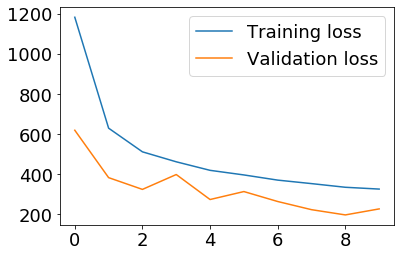

In [160]:
# plot losses
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

Test period 79:
Mean model error raw: -11.6 +/- 17.8
Mean model error calibrated: -15.6 +/- 24.0


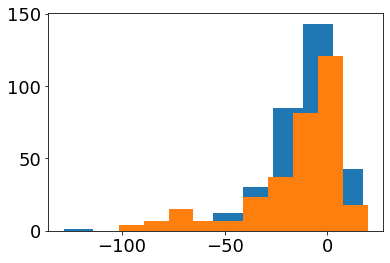

In [161]:
# intermediate test for model on unseen, un-shuffled data, after pre-training
model.load_weights(model_directory)

plt.hist(Y_data_test_flat)
P=model.predict(X_data_test.reshape(np.array(X_data_test.shape[:2]).prod(),2*range_pixels,2*range_pixels,4))
plt.hist(Y_data_test_flat-P)

print('Test period '+str(k+1)+':')
print('Mean model error raw: ' + str('%.1f' % np.nanmean(Y_data_test_flat))+ ' +/- '+str( '%.1f' %np.nanstd(Y_data_test_flat)))
print('Mean model error calibrated: ' + str( '%.1f' %np.nanmean(Y_data_test_flat-P))+ ' +/- '+str( '%.1f' %np.nanstd(Y_data_test_flat-P)))


In [163]:
# train model on target data
history = model.fit(X_data_train, Y_data_train, epochs=7,validation_split = 0.1,batch_size=50)
# Save the weights
model.save_weights(model_directory)

Epoch 1/2
239/239 [==============================] - 40s 166ms/step - loss: 243.6132 - val_loss: 119.9071
Epoch 2/2
239/239 [==============================] - 40s 167ms/step - loss: 248.5431 - val_loss: 94.8075


Test period 79:
Mean model error raw: -11.6 +/- 17.8
Mean model error calibrated: -7.5 +/- 16.4


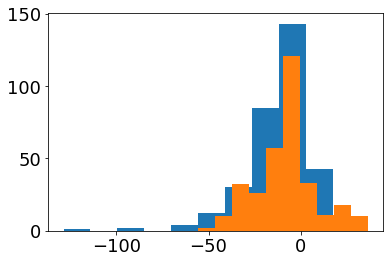

In [164]:
# test for model on unseen, un-shuffled data, after training
model.load_weights(model_directory)

plt.hist(Y_data_test_flat)
P=model.predict(X_data_test.reshape(np.array(X_data_test.shape[:2]).prod(),2*range_pixels,2*range_pixels,4))
plt.hist(Y_data_test_flat-P)

print('Test period '+str(k+1)+':')
print('Mean model error raw: ' + str('%.1f' % np.nanmean(Y_data_test_flat))+ ' +/- '+str( '%.1f' %np.nanstd(Y_data_test_flat)))
print('Mean model error calibrated: ' + str( '%.1f' %np.nanmean(Y_data_test_flat-P))+ ' +/- '+str( '%.1f' %np.nanstd(Y_data_test_flat-P)))


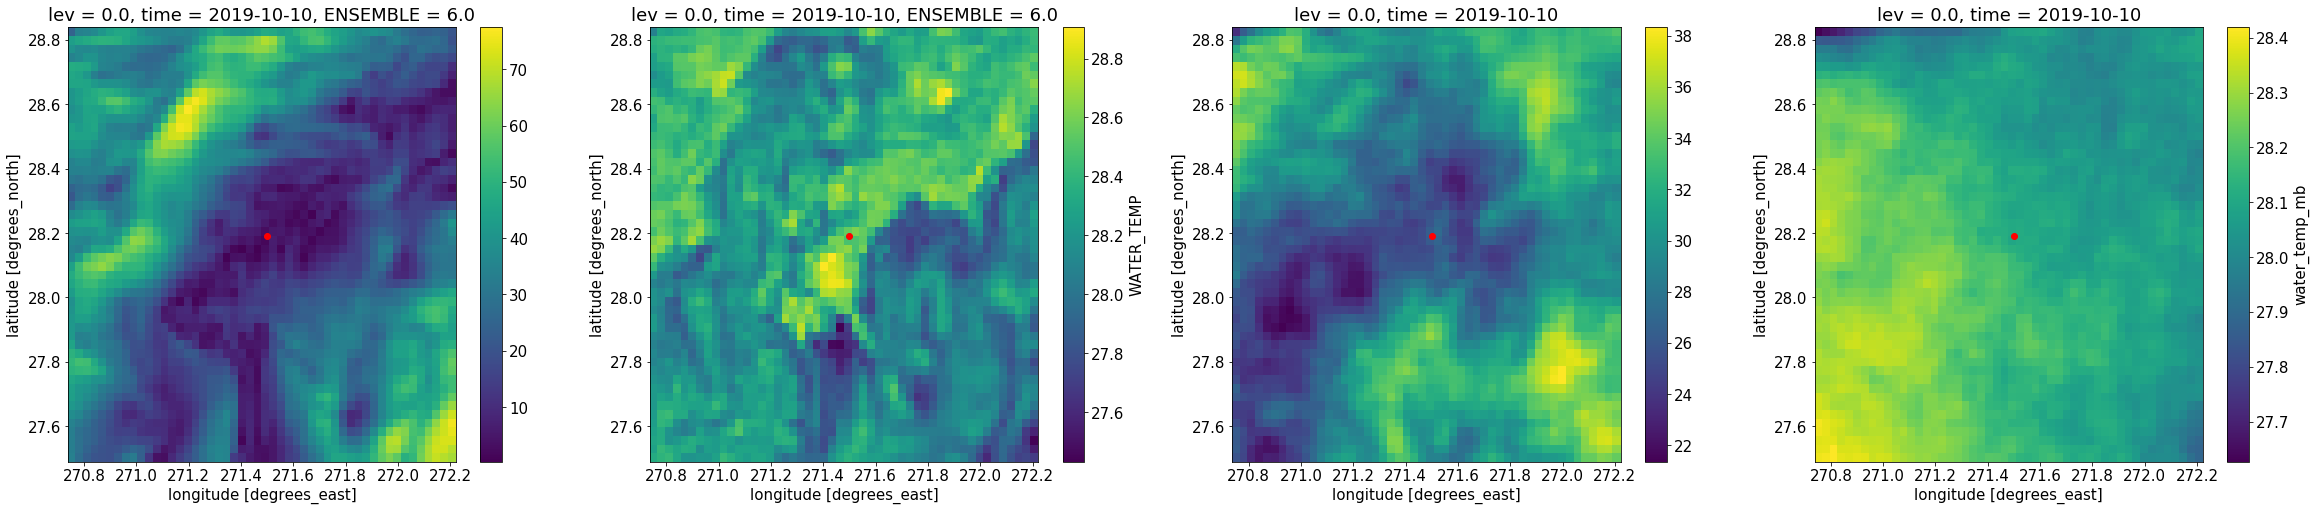

In [92]:
# plot some example images going into the CNN
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(40,8))
plt.subplot(141)
s[5,:,:].plot()
plt.plot(271.5,28.19,'ro')
plt.subplot(142)
t[5,:,:].plot()
plt.plot(271.5,28.19,'ro')
plt.subplot(143)
sm[:,:].plot()
plt.plot(271.5,28.19,'ro')
plt.subplot(144)
tm[:,:].plot()
plt.plot(271.5,28.19,'ro')
plt.savefig('./example_input.png')

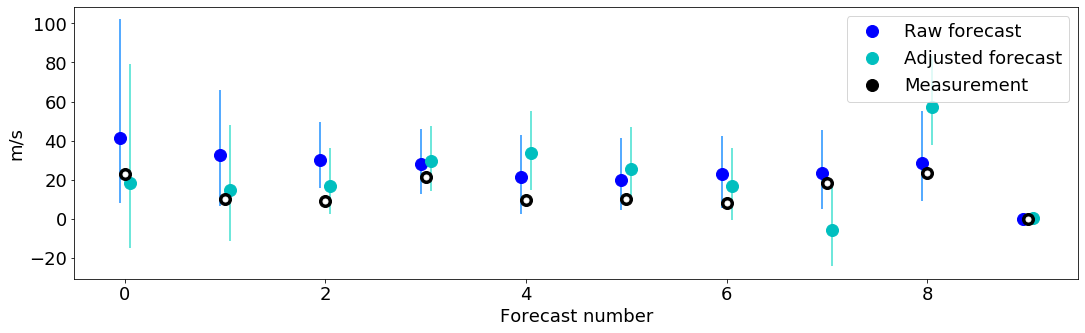

In [165]:
# finally, plot what predicted error from the CNN model would do to the unseen forecasts
# Here, we use the mean of the corrected forecast to adjust the mean of the raw forecast
# Since the CNN model is trained to bias correct individual ensemble members, it changes the spread of the forecast.
# The spread of the CNN-corrected ensemble is not calibrated, whereas the spread of the raw model is, so we
# keep the ensemble spread of the raw forecast but correct the mean

plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(18,5))
for k in range(Y_data_test.shape[0]):
    p=X_data_test[k,:,range_pixels,range_pixels,0]
    pc=model.predict(X_data_test[k,:,:,:,:])
    measured_data=Y_data_test[k,:]+p
    plt.plot((k-0.05),np.mean(p),'bo', markersize=12, label='Raw forecast')
    
    plt.plot((k+0.05),np.mean(p+np.mean(pc)),'co', markersize=12, label='Adjusted forecast')
    p1=np.percentile(p,5)
    p2=np.percentile(p,95)
    err=np.empty((2,1))
    err[0,0]=abs(p1-np.mean(p))
    err[1,0]=p2-np.mean(p)
    plt.errorbar((k+0.05),np.mean(p+np.mean(pc)),yerr=err,ecolor='turquoise')
    plt.errorbar((k-0.05),np.mean(p),yerr=err,ecolor='dodgerblue')
    plt.plot(k,measured_data[0],'ko', markersize=12, label='Measurement')
    plt.plot(k,measured_data[0],'wo', markersize=5)
plt.xlabel('Forecast number')
plt.ylabel('m/s')
plt.legend(['Raw forecast', 'Adjusted forecast', 'Measurement'])
plt.savefig('./forecast_adj_test.png')